In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# Establish connection. database needs to be in the same folder as notebook 
conn = sqlite3.connect("database.sqlite")

# Then create a Cursor object from which we can call the execute() method and to perform SQL statements and queries.
c = conn.cursor()

In [3]:
raw_data = pd.read_sql("""
                       SELECT pub_rec_bankruptcies, earliest_cr_line, issue_d,  annual_inc, dti, emp_length, loan_amnt, int_rate,
                       home_ownership, term, loan_status
                       FROM loan
                       WHERE application_type in ('Individual')
                       """, con=conn)

In [4]:
# Create a list of columns that are NOT numeric values
not_numeric_cols = ['emp_length', 'loan_status', 'home_ownership', 'issue_d',
                    'earliest_cr_line', 'purpose', 'term']

# Create list of columns that ARE numeric values and print
numeric_cols = [col for col in raw_data.columns if col not in not_numeric_cols]
print(numeric_cols)

# Convert numeric cols into numeric data types
raw_data[numeric_cols] = raw_data[numeric_cols].apply(pd.to_numeric)

['pub_rec_bankruptcies', 'annual_inc', 'dti', 'loan_amnt', 'int_rate']


In [5]:
# Create list of datetime columns
datetime_cols = ['earliest_cr_line', 'issue_d']

# Convert to datetime
raw_data[datetime_cols] = raw_data[datetime_cols].apply(pd.to_datetime)

In [6]:
preprocess_df = raw_data
preprocess_df.dtypes

pub_rec_bankruptcies           float64
earliest_cr_line        datetime64[ns]
issue_d                 datetime64[ns]
annual_inc                     float64
dti                            float64
emp_length                      object
loan_amnt                        int64
int_rate                       float64
home_ownership                  object
term                            object
loan_status                     object
dtype: object

# Missing Data / Missing Observations

In [7]:
preprocess_df.isnull().sum()

pub_rec_bankruptcies    1365
earliest_cr_line          29
issue_d                    0
annual_inc                 4
dti                        0
emp_length                 0
loan_amnt                  0
int_rate                   0
home_ownership             0
term                       0
loan_status                0
dtype: int64

# Character: pub_rec_bankruptcies & earliest_cr_line
What it is: A lender’s opinion of a borrower’s general trustworthiness, credibility and personality.

Why it matters: Banks want to lend to people who are responsible and keep commitments.

How it’s assessed: From your work experience, credit history, credentials, references, reputation and interaction with lenders.

In [8]:
character_df = preprocess_df[['pub_rec_bankruptcies', 'earliest_cr_line', 'issue_d']].copy()

In [9]:
print(character_df.head())
print(character_df.describe())
print(character_df.dtypes)

   pub_rec_bankruptcies earliest_cr_line    issue_d
0                   1.0       2001-04-01 2018-12-01
1                   1.0       1987-06-01 2018-12-01
2                   0.0       2011-04-01 2018-12-01
3                   0.0       2006-02-01 2018-12-01
4                   0.0       2000-12-01 2018-12-01
       pub_rec_bankruptcies
count          2.138593e+06
mean           1.281576e-01
std            3.655991e-01
min            0.000000e+00
25%            0.000000e+00
50%            0.000000e+00
75%            0.000000e+00
max            1.200000e+01
pub_rec_bankruptcies           float64
earliest_cr_line        datetime64[ns]
issue_d                 datetime64[ns]
dtype: object


<code>'earliest_cr_line'</code> shows the first credit line on the customer credit report. 

Will create a new feature that shows the number of months between the first credit line in the customers history and the issue date of the loan.

In [10]:
# fill the missing value for earliest_cr_line with most frequently occuring
character_df['earliest_cr_line'].fillna(character_df['earliest_cr_line'].value_counts().index[0], inplace=True)

In [11]:
# count months between now and 'earliest_cr_line'
character_df['credit_hist_in_months'] = ((character_df['issue_d'] - character_df['earliest_cr_line'])/np.timedelta64(1, 'M'))
character_df['credit_hist_in_months'] = character_df['credit_hist_in_months'].astype(int)

character_df.head()

,pub_rec_bankruptcies,earliest_cr_line,issue_d,credit_hist_in_months
0,1.0,2001-04-01,2018-12-01,212
1,1.0,1987-06-01,2018-12-01,378
2,0.0,2011-04-01,2018-12-01,92
3,0.0,2006-02-01,2018-12-01,153
4,0.0,2000-12-01,2018-12-01,215


In [12]:
# Create a new binary feature of whether or not there is a bankruptcy on file in customers credit history
character_df['cb_person_bk_on_file_Y'] = character_df['pub_rec_bankruptcies'].apply(lambda x: 1 if x >= 1 else 0)
character_df['cb_person_bk_on_file_N'] = character_df['pub_rec_bankruptcies'].apply(lambda x: 1 if x < 1 else 0)
character_df.head()

,pub_rec_bankruptcies,earliest_cr_line,issue_d,credit_hist_in_months,cb_person_bk_on_file_Y,cb_person_bk_on_file_N
0,1.0,2001-04-01,2018-12-01,212,1,0
1,1.0,1987-06-01,2018-12-01,378,1,0
2,0.0,2011-04-01,2018-12-01,92,0,1
3,0.0,2006-02-01,2018-12-01,153,0,1
4,0.0,2000-12-01,2018-12-01,215,0,1


In [13]:
# drop the old features from the character_df
character_df.drop(['pub_rec_bankruptcies', 'earliest_cr_line', 'issue_d'], axis=1, inplace=True)
character_df.head()

,credit_hist_in_months,cb_person_bk_on_file_Y,cb_person_bk_on_file_N
0,212,1,0
1,378,1,0
2,92,0,1
3,153,0,1
4,215,0,1


# Capacity/Cash flow: annual_inc & dti
What it is: Your ability to repay the loan.

Why it matters: Lenders want to be assured that your business generates enough cash flow to repay the loan in full.

In [14]:
capacity_df = preprocess_df[['annual_inc', 'dti']].copy()
capacity_df.head()

,annual_inc,dti
0,55000.0,18.24
1,90000.0,26.52
2,59280.0,10.51
3,92000.0,16.74
4,57250.0,26.35


In [15]:
# fill missing values for annual income with the mean
capacity_df['annual_inc'] = capacity_df['annual_inc'].fillna(capacity_df['annual_inc'].mean())

In [16]:
# describe the capacity/cash flow proxy features
print(capacity_df[['annual_inc', 'dti']].describe())

         annual_inc           dti
count  2.139958e+06  2.139958e+06
mean   7.900108e+04  1.809316e+01
std    1.150763e+05  8.425408e+00
min    1.896000e+03 -1.000000e+00
25%    4.740000e+04  1.178000e+01
50%    6.530000e+04  1.760000e+01
75%    9.500000e+04  2.404000e+01
max    1.100000e+08  4.996000e+01


In [17]:
f"Minimum Annual Income in the Dataset is ${capacity_df.annual_inc.min()} and maximum annual income in the Dataset is {capacity_df.annual_inc.max()}"

'Minimum Annual Income in the Dataset is $1896.0 and maximum annual income in the Dataset is 110000000.0'

In [18]:
f"Minimum debt-to-income in the Dataset is {capacity_df.dti.min()} and maximum debt-to-income in the Dataset is {capacity_df.dti.max()}"

'Minimum debt-to-income in the Dataset is -1.0 and maximum debt-to-income in the Dataset is 49.96'

# Capital
What it is: The amount of money invested by the business owner or management team.

Why it matters: Banks are more willing to lend to owners who have invested some of their own money into the venture. It shows you have some “skin in the game.”

How it’s assessed: From the amount of money the borrower or management team has invested in the business.

# <i>NO PROXY FEATURES USED FOR CAPITAL<i>

# Conditions : loan_amnt, int_rate, term
What it is: The condition of your business — whether it is growing or faltering — as well as what you’ll use the funds for. It also considers the state of the economy, industry trends and how these factors might affect your ability to repay the loan.

Why it matters: To ensure that loans are repaid, banks want to lend to businesses operating under favorable conditions. They aim to identify risks and protect themselves accordingly.

How it’s assessed: From a review of the competitive landscape, supplier and customer relationships, and macroeconomic and industry-specific issues.

In [19]:
conditions_df = preprocess_df[['loan_amnt', 'int_rate', 'term']].copy()

In [20]:
conditions_df.term.value_counts()

 36 months    1539983
 60 months     599975
Name: term, dtype: int64

In [21]:
# Convert values of term to 0, 1 where 0 = 36 months and 1 = 60 months
conditions_df['term'] = conditions_df['term'].replace({' 36 months': '0',
                                                       ' 60 months': '1'})

# convert term into an integer data type 
conditions_df['term'] = conditions_df['term'].astype(int)

# Rename term column
conditions_df = conditions_df.rename(columns={'term': 'term_60'})

print(conditions_df.term_60.value_counts())
conditions_df.head()

0    1539983
1     599975
Name: term_60, dtype: int64


,loan_amnt,int_rate,term_60
0,2500,13.56,0
1,30000,18.94,1
2,5000,17.97,0
3,4000,18.94,0
4,30000,16.14,1


# Collateral: home_ownership
What it is: Assets that are used to guarantee or secure a loan.

Why it matters: Collateral is a backup source if the borrower cannot repay a loan.

In [22]:
collateral_df = preprocess_df[['home_ownership']].copy()
collateral_df.head()

,home_ownership
0,RENT
1,MORTGAGE
2,MORTGAGE
3,MORTGAGE
4,MORTGAGE


In [23]:
# create emp_length dummy data frame
home_ownership = pd.DataFrame(pd.get_dummies(collateral_df['home_ownership'], prefix='home_ownership'))

# join the loan_amnt dummy dataframe to conditions_df
collateral_df = pd.concat([collateral_df, home_ownership], axis=1, sort=False)

# drop original emp_length feature
collateral_df.drop(['home_ownership'], axis=1, inplace=True)

collateral_df.head()

,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,0,0,0,0,0,1
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


# Loan Status

Current Status of the Loan. Target variable

In [24]:
loan_status_df = preprocess_df[['loan_status']].copy()
loan_status_df.loan_status.value_counts()

Fully Paid                                             1024444
Current                                                 825914
Charged Off                                             255926
Late (31-120 days)                                       19716
In Grace Period                                           7862
Late (16-30 days)                                         3323
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     24
Name: loan_status, dtype: int64

Remap loan_status values. Charged Off, Late, & In Grace Period are considered to be technical defaults. 0 is Non-default, 1 is Default

In [25]:
loan_status_df['loan_status'] = loan_status_df['loan_status'].replace({'Fully Paid': 0, 'Current': 0, 'Charged Off': 1,
                                                                       'Late (31-120 days)': 1, 'In Grace Period': 1,
                                                                       'Late (16-30 days)':1,
                                                                       'Does not meet the credit policy. Status:Fully Paid': 0,
                                                                       'Does not meet the credit policy. Status:Charged Off': 1,
                                                                       'Default':1})
loan_status_df.loan_status.value_counts()

0    1852346
1     287612
Name: loan_status, dtype: int64

# Combine all the processed dataframes together into a single one

In [26]:
# Concatenate all the processed dataframes into a single one
processed_df = pd.concat([character_df,
                          capacity_df,
                          conditions_df,
                          collateral_df,
                          loan_status_df], axis=1, sort=False)
processed_df.head()

,credit_hist_in_months,cb_person_bk_on_file_Y,cb_person_bk_on_file_N,annual_inc,dti,loan_amnt,int_rate,term_60,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,loan_status
0,212,1,0,55000.0,18.24,2500,13.56,0,0,0,0,0,0,1,0
1,378,1,0,90000.0,26.52,30000,18.94,1,0,1,0,0,0,0,0
2,92,0,1,59280.0,10.51,5000,17.97,0,0,1,0,0,0,0,0
3,153,0,1,92000.0,16.74,4000,18.94,0,0,1,0,0,0,0,0
4,215,0,1,57250.0,26.35,30000,16.14,1,0,1,0,0,0,0,0


# Count total Non-Defualt and Defaulted Loans in the Data Set

Where 

'0' is a loan that has NOT defaulted 

and 

'1' is a loan that HAS defaulted

In [27]:
print(processed_df.loan_status.value_counts())

0    1852346
1     287612
Name: loan_status, dtype: int64


Text(0, 0.5, 'Number of Loans')

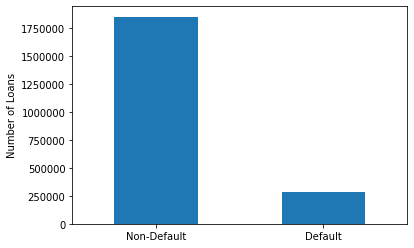

In [28]:
ax = processed_df.loan_status.value_counts().plot(kind='bar')
labels = ['Non-Default', 'Default']
ax.set_xticklabels(labels, rotation='horizontal')
ax.set_ylabel('Number of Loans')

# Correlation in Credit Features

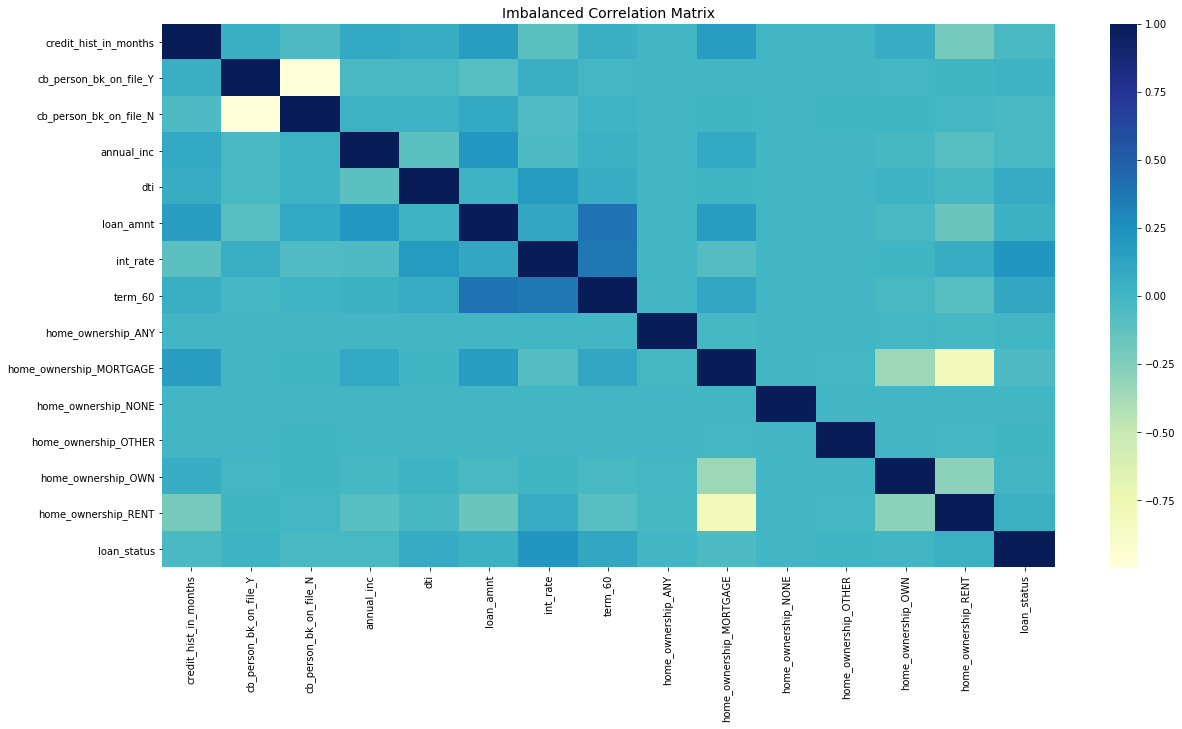

In [29]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))

# Imbalanced DataFrame Correlation
corr = processed_df.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)
plt.show()

# Undersampling

The process where you randomly delete some of the observations from the majority class in order to match the numbers with the minority class

In [30]:
# Shuffle the Dataset.
random_data = processed_df.sample(frac=1,random_state=4)

# Put all the fraud class in a separate dataset.
default_df = random_data.loc[random_data['loan_status'] == 1]

#Randomly select 287612 observations from the non-fraud (majority class)
non_default_df = random_data.loc[random_data['loan_status'] == 0].sample(n=287612,random_state=42)

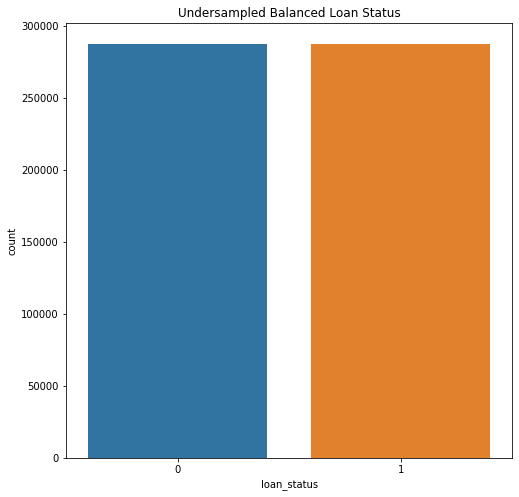

In [31]:
# Concatenate both dataframes again
US_df = pd.concat([default_df, non_default_df])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('loan_status', data=US_df)
plt.title('Undersampled Balanced Loan Status')
plt.show()

In [32]:
# Create X and y using undersampled dataframe
X = US_df.drop(['loan_status'], axis=1)
y = US_df['loan_status']

X_train_US, X_test_US, y_train_US, y_test_US = train_test_split(X, y, test_size=.4, random_state=123)

In [33]:
# Create, train, and fit a logistic regression model
from sklearn.linear_model import LogisticRegression
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train_US, np.ravel(y_train_US))

# Create predictions of probability for loan status using test data
# .predict_proba creates an array of probabilities of default: [[non-defualt, default]]
lr_preds = clf_logistic.predict_proba(X_test_US)

# # Create dataframes of predictions and true labels
lr_preds_df = pd.DataFrame(lr_preds[:,1][0:], columns = ['lr_pred_PD'])
true_df = y_test_US

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), lr_preds_df], axis = 1))

        loan_status  lr_pred_PD
0                 0    0.578071
1                 0    0.607914
2                 0    0.372572
3                 0    0.624609
4                 0    0.268229
...             ...         ...
230085            1    0.339767
230086            0    0.341947
230087            0    0.500175
230088            1    0.413517
230089            1    0.500663

[230090 rows x 2 columns]


In [34]:
# Reassign loan status based on the threshold and print the predictions
lr_preds_df['lr_pred_loan_status_60'] = lr_preds_df['lr_pred_PD'].apply(lambda x: 1 if x > 0.60 else 0)
print("Default / Non-default predictions at 60% Threshhold: ")
print(lr_preds_df['lr_pred_loan_status_60'].value_counts())

# Print the confusion matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix at 60% Threshhold: ")
print(confusion_matrix(y_test_US, lr_preds_df['lr_pred_loan_status_60']))

# Print the classification report
from sklearn.metrics import classification_report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test_US, lr_preds_df['lr_pred_loan_status_60'], target_names=target_names))

Default / Non-default predictions at 60% Threshhold: 
0    169640
1     60450
Name: lr_pred_loan_status_60, dtype: int64
Confusion Matrix at 60% Threshhold: 
[[95286 20047]
 [74354 40403]]
              precision    recall  f1-score   support

 Non-Default       0.56      0.83      0.67    115333
     Default       0.67      0.35      0.46    114757

    accuracy                           0.59    230090
   macro avg       0.62      0.59      0.56    230090
weighted avg       0.61      0.59      0.57    230090



In [35]:
# Reassign loan status based on the threshold and print the predictions
lr_preds_df['lr_pred_loan_status_50'] = lr_preds_df['lr_pred_PD'].apply(lambda x: 1 if x > 0.50 else 0)
print("Default / Non-default predictions at 50% Threshhold: ")
print(lr_preds_df['lr_pred_loan_status_50'].value_counts())

# Print the confusion matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix at 50% Threshhold: ")
print(confusion_matrix(y_test_US, lr_preds_df['lr_pred_loan_status_50']))

# Print the classification report
from sklearn.metrics import classification_report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test_US, lr_preds_df['lr_pred_loan_status_50'], target_names=target_names))

Default / Non-default predictions at 50% Threshhold: 
1    135268
0     94822
Name: lr_pred_loan_status_50, dtype: int64
Confusion Matrix at 50% Threshhold: 
[[60298 55035]
 [34524 80233]]
              precision    recall  f1-score   support

 Non-Default       0.64      0.52      0.57    115333
     Default       0.59      0.70      0.64    114757

    accuracy                           0.61    230090
   macro avg       0.61      0.61      0.61    230090
weighted avg       0.61      0.61      0.61    230090



# Oversampling

The process of generating synthetic data that tries to randomly generate a sample of the attributes from observations in the minority class. There are a number of methods used to oversample a dataset for a typical classification problem. The most common technique is called SMOTE (Synthetic Minority Over-sampling Technique)

In [36]:
# Create X and y using processed_df

X = processed_df.drop(['loan_status'], axis=1)
y = processed_df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

In [37]:
from imblearn.over_sampling import SMOTE

# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='minority', random_state=7)

# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_sample(X_train, y_train)
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
oversampled_train.columns = processed_df.columns

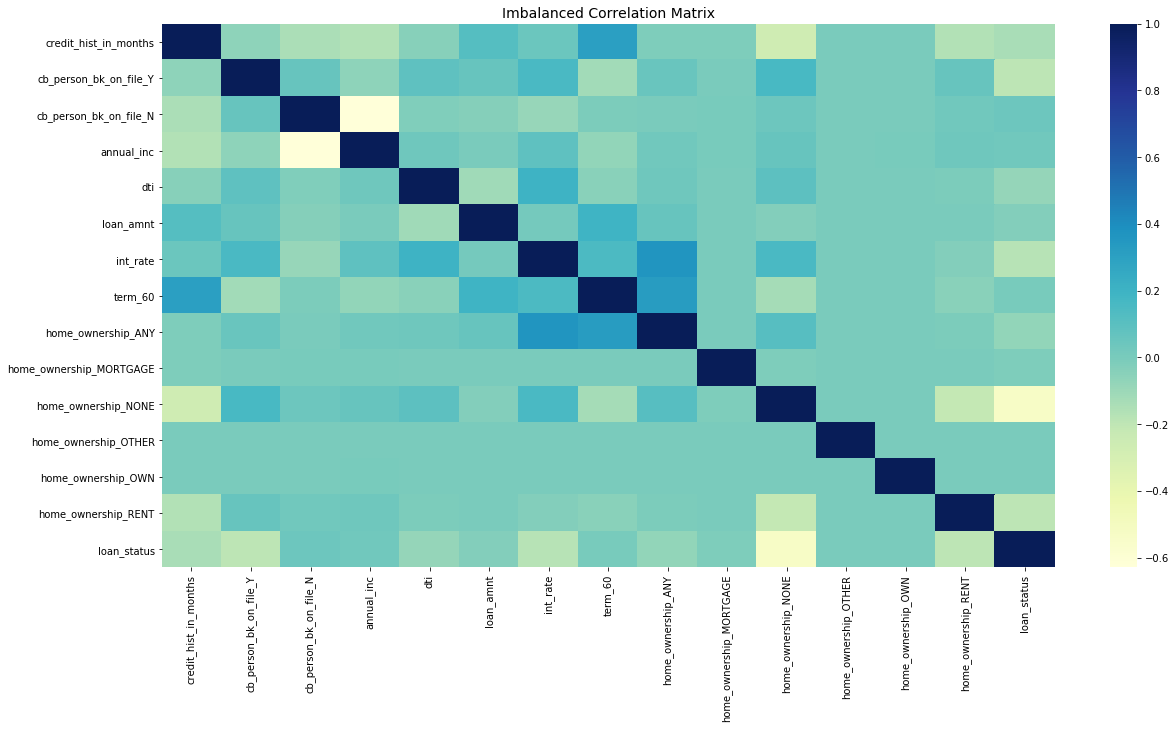

In [38]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))

# Imbalanced DataFrame Correlation
corr = oversampled_train.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)
plt.show()

In [39]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Create an object of the classifier and fit oversampled training data to the object
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0).fit(oversampled_trainX, np.ravel(oversampled_trainY))

# Create predictions of probability for loan status using test data
bbc_preds = bbc.predict_proba(X_test)

In [40]:
# Create dataframes of predictions and true labels
bbc_preds_df = pd.DataFrame(bbc_preds[:,1][0:], columns = ['bbc_pred_PD'])
true_df = y_test

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), bbc_preds_df], axis = 1))

        loan_status  bbc_pred_PD
0                 0          0.6
1                 0          0.0
2                 0          0.0
3                 0          0.1
4                 0          0.1
...             ...          ...
855979            1          0.1
855980            0          0.3
855981            0          0.0
855982            1          0.8
855983            1          0.1

[855984 rows x 2 columns]


In [41]:
# Reassign loan status based on the threshold and print the predictions
bbc_preds_df['bbc_pred_loan_status_60'] = bbc_preds_df['bbc_pred_PD'].apply(lambda x: 1 if x > 0.50 else 0)
print("Default / Non-default predictions at 60% Threshhold: ")
print(bbc_preds_df['bbc_pred_loan_status_60'].value_counts())

# Print the confusion matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix at 60% Threshhold: ")
print(confusion_matrix(y_test, bbc_preds_df['bbc_pred_loan_status_60']))

# Print the classification report
from sklearn.metrics import classification_report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, bbc_preds_df['bbc_pred_loan_status_60'], target_names=target_names))


Default / Non-default predictions at 60% Threshhold: 
0    813611
1     42373
Name: bbc_pred_loan_status_60, dtype: int64
Confusion Matrix at 60% Threshhold: 
[[710236  30952]
 [103375  11421]]
              precision    recall  f1-score   support

 Non-Default       0.87      0.96      0.91    741188
     Default       0.27      0.10      0.15    114796

    accuracy                           0.84    855984
   macro avg       0.57      0.53      0.53    855984
weighted avg       0.79      0.84      0.81    855984



In [42]:
# Reassign loan status based on the threshold and print the predictions
bbc_preds_df['bbc_pred_loan_status_50'] = bbc_preds_df['bbc_pred_PD'].apply(lambda x: 1 if x > 0.50 else 0)
print("Default / Non-default predictions at 50% Threshhold: ")
print(bbc_preds_df['bbc_pred_loan_status_50'].value_counts())

# Print the confusion matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix at 50% Threshhold: ")
print(confusion_matrix(y_test, bbc_preds_df['bbc_pred_loan_status_50']))

# Print the classification report
from sklearn.metrics import classification_report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, bbc_preds_df['bbc_pred_loan_status_50'], target_names=target_names))


Default / Non-default predictions at 50% Threshhold: 
0    813611
1     42373
Name: bbc_pred_loan_status_50, dtype: int64
Confusion Matrix at 50% Threshhold: 
[[710236  30952]
 [103375  11421]]
              precision    recall  f1-score   support

 Non-Default       0.87      0.96      0.91    741188
     Default       0.27      0.10      0.15    114796

    accuracy                           0.84    855984
   macro avg       0.57      0.53      0.53    855984
weighted avg       0.79      0.84      0.81    855984

